In [7]:
%matplotlib ipympl
import scipy.signal as signal
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.widgets import RectangleSelector
import skimage.util as sk_util
import scipy.ndimage as ndimage
from skimage.color import rgb2gray
from skimage.morphology import disk
from skimage.io import imread
import matplotlib
import skimage.restoration as restoration

import skimage.filters.rank as rank
plt.gray()
def PSNR(f,g):
    return 10*np.log10(1.0/ np.mean(np.square(f-g)))


class Selector:
    def __init__(self, ax):
        self.RS = RectangleSelector(ax, self.line_select_callback,
                                     useblit=True,
                                       button=[1, 3],  
                                       minspanx=5, minspany=5,
                                       spancoords='pixels',
                                       interactive=True)
        self.bbox = [None, None, None, None]
        
    def line_select_callback(self,eclick, erelease):
        'eclick and erelease are the press and release events'
        x1, y1 = eclick.xdata, eclick.ydata
        x2, y2 = erelease.xdata, erelease.ydata
        self.bbox = [int(y1), int(y2), int(x1), int(x2)]
    def get_bbox(self):
        return self.bbox

f = imread('../lab_images/cameraman.tif').astype(np.float64)/255
I = imread('../lab_images/degraded.tif').astype(np.float64)/255

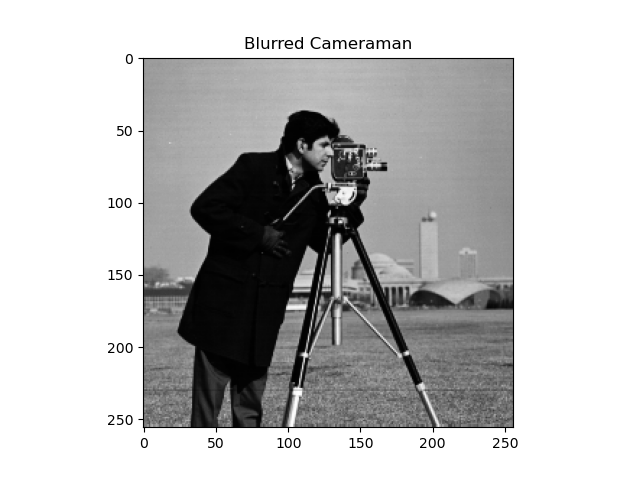

Text(0.5, 1.0, 'Cameraman')

In [9]:
plt.imshow(f)
plt.show()
plt.title("Cameraman")


In [3]:
f.max(), f.min()

(0.9921568627450981, 0.027450980392156862)

In [10]:
h_d = disk(4)
h = np.zeros((256,256))
h[0:9,0:9] = h_d
h = np.roll(h, (-5,-5)) / np.sum(h)
h_freq = np.fft.fft2(h)
f_blurfreq = h_freq*np.fft.fft2(f)
f_blur = np.real(np.fft.ifft2(f_blurfreq))

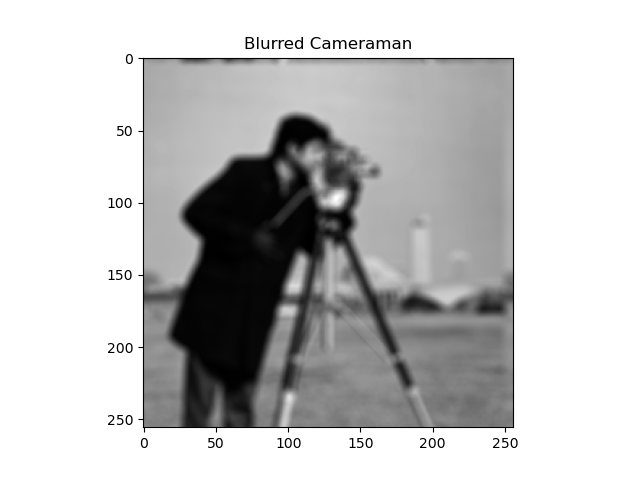

In [11]:
# plot the blurred image
plt.title("Blurred Cameraman")
plt.imshow(f_blur)
plt.show()

In [12]:
print(f"The PSNR between the original and blurred cameraman is {round(PSNR(f, f_blur), 3)}")

The PSNR between the original and blurred cameraman is 16.313


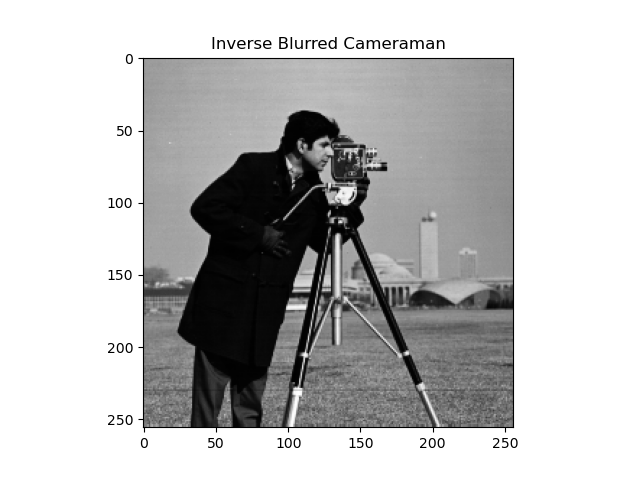

In [13]:
# apply inverse filtering
f_blur_inv_freq = f_blurfreq / h_freq
f_blur_inv = np.real(np.fft.ifft2(f_blur_inv_freq))


plt.title("Inverse Blurred Cameraman")
plt.imshow(f_blur_inv)
plt.show()

In [8]:
print(f"The PSNR between the original and inverse blurred cameraman is {round(PSNR(f, f_blur_inv), 3)}")

The PSNR between the original and inverse blurred cameraman is 316.612


## Part 2.

1. Compare the restored image with the original image and the blurred image. How does the restored image and the PSNR differ from the blurred image? Is it better or worse? Why?

The restored image looks much more visually appealing and has a much higher PSNR than the blurred image. This makes sense since the blurred image has no noise added; it is only blur degraded. Since we know the blur filter, we can exactly compensate for the blur by applying the inverse: (F * H) / H = F. Thus, since the image has no noise, the inverse perfectly recovers it, as observed. We also note that the image blurred in the frequency domain looks blurred as expected.

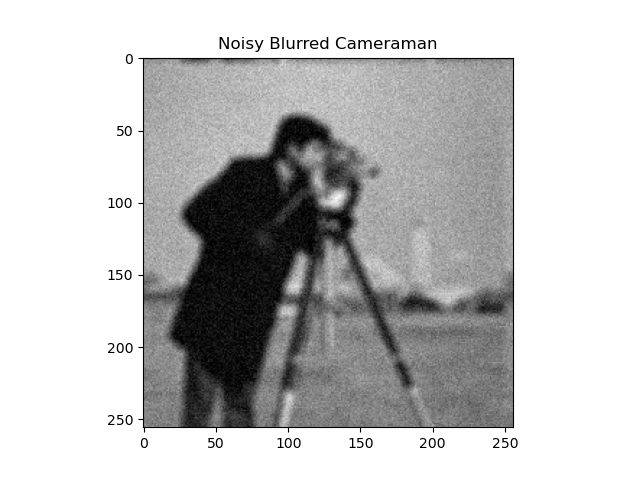

In [14]:
# add zero mean gaussian noise to the blurred image
f_blurred_noisy = sk_util.random_noise(f_blur, mode="gaussian", var=0.002)
plt.title("Noisy Blurred Cameraman")
plt.imshow(f_blurred_noisy)
plt.show()


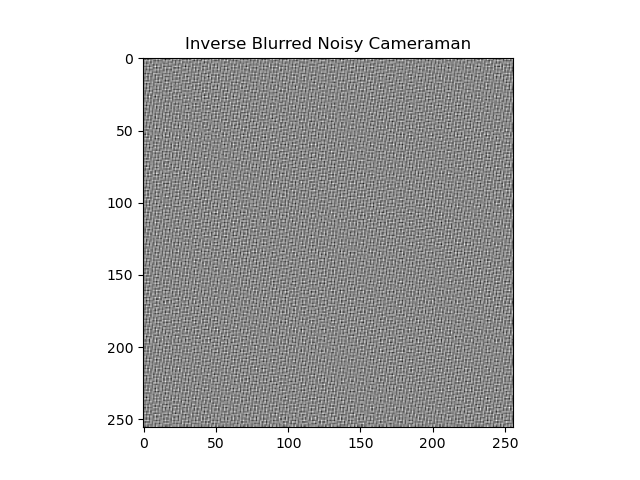

In [15]:
# apply inverse filtering for the blur operation
f_noisy_blur_inv_freq = np.fft.fft2(f_blurred_noisy) / h_freq
f_noisy_blur_inv = np.real(np.fft.ifft2(f_noisy_blur_inv_freq))

plt.title("Inverse Blurred Noisy Cameraman")
plt.imshow(f_noisy_blur_inv)
plt.show()

In [16]:
print(f"The PSNR between the original and noisy blurred cameraman is {PSNR(f, f_noisy_blur_inv)}")

The PSNR between the original and noisy blurred cameraman is -42.87043547809056


## Part 2
2. Compare the restored image with the restored image from the previous step. How does the restored image and the PSNR differ from the previous restored image? Is it better or worse? Why?

The restored image in this step is much worse than the restored image in the previous step. This is evident as the image is completely unrecognizable and the PSNR has dropped to -42 from 320 before! The reason for the large decrease in image quality is the additive gaussian noise. When adding noise, inverse filtering is a bad idea. This can be mathematically seen in the frequency domain: assume F_hat = H * G, where G is a degraded noisy image and H is the filter we are using to restore the image (nverse filtering). Now, assuming we know H = H_freq, then inverse filtering yields F_hat = G / H_freq => F_hat = (F * H_freq + N_freq) / H_freq = F + N / H_freq. Given this formula, we note that if H_freq is small, then the noise term dominates and the resultant F_hat is bad. This is precicely what has happened in this case - the noise term has dominated so the inverse filtered image is terrible. 

3. Can you draw any conclusions about inverse filtering when applied to noise degraded images?

Applying inverse filtering to noise degraded images will not work well. In general, the noise will domainate the signal, and the resultant image will not be of good quality (unless there is only very very small amounts of noise in the image, where the noise is negligible... however this is rarely the case). 

In [12]:
# need to approx the noise to signal ratio
# note that the variance is 0.002, and image max is 1
avg = f_noisy_blur_inv.mean()
avg

0.4659011374558806

In [13]:
# note that mean signal value is 0.465. The noise may be about 1 standard deviation away => sqrt(0.002)
standard_dev = np.sqrt(0.002)
standard_dev

0.044721359549995794

In [14]:
nsr = standard_dev / avg
print(f"The noise to signal ratio is about {round(nsr, 2)}")

The noise to signal ratio is about 0.1


In [17]:
shifted_psf = np.fft.fftshift(np.real(np.fft.ifft2(h_freq)))

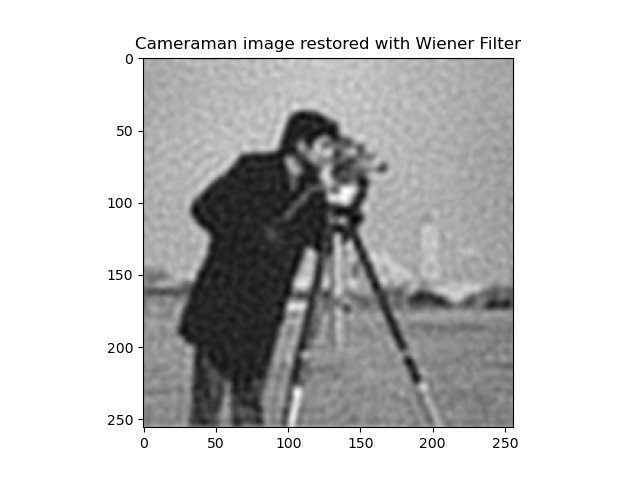

In [18]:
# apply the weiner filter on the noisy, blurred image
restored_wiener = restoration.wiener(f_blurred_noisy, shifted_psf, 0.1)
plt.title("Cameraman image restored with Wiener Filter")
plt.imshow(restored_wiener)
plt.show()

In [19]:
print(f"The PSNR between the original and weiner restored cameraman is {PSNR(f, restored_wiener)}")

The PSNR between the original and weiner restored cameraman is 22.682050252144027


## Part 2 Qs

4. Compare the restored image with the restored image from the previous step. How does the restored image and the PSNR differ from the previous restored image? Is it better or worse? Why? Explain it in context with the concept behind Wiener filtering.

The restored image from Wiener filtering is much better than of inverse filtering. The PSNR this time increase from -40 to about 23. The wiener filter works much better because it applies selective filtering based on whether or not the SNR is high or low in the image. More specifically, from the weiner filter formula, we can see that if the SNR is high (ie. the image has good quality), then the weinern filter will approximate the inverse filter, as there is low noise so we can take the inverse and get back the undegraded image. However, if the SNR is low, then there is lots of noise and the weiner filter goes to 0 (in order to get rid of the noise and avoid the effects of noise as seen in inverse filtering). Thus, the weiner filter combines the degradation with noise in order to achieve a good result, as observed.

5. Can you draw any conclusions about Wiener filtering when applied to noise degraded images?

Wiener filtering works well under conditions where there is both noise and a degradation. We can see from this example that if we have a reasonable estimate of the degredation model but get terrible results from inverse filtering, it will likely be on account of the noise. This should lead us to try weiner filtering - a technique that will be robust to additive noise after a degradation. In general, we can expect good results when applying wiener filtering to noise degraded images.

## Part 3

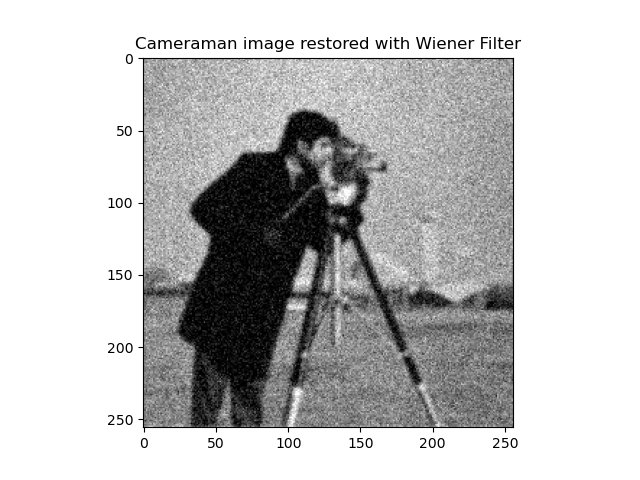

Text(0.5, 1.0, 'Degraded image')

In [20]:
plt.imshow(I)
plt.show()
plt.title("Degraded image")

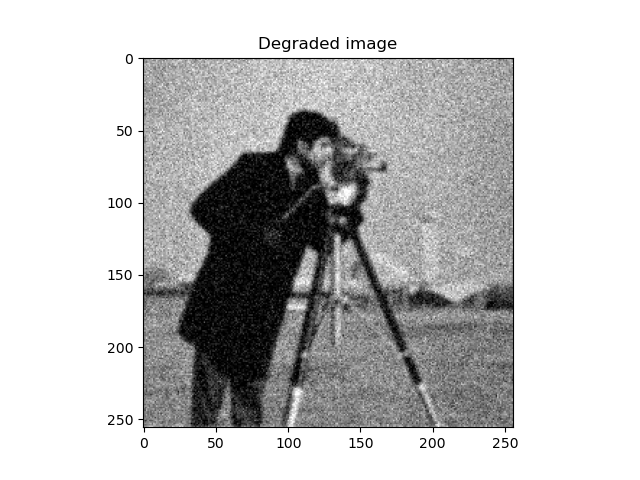

In [21]:
# Q6
# note that there are illumination effects right above the cameraman, so we will use a patch in the top right corner to estimate the noise
# copy the code from the example to select the patch
ax = plt.gca()
ax.imshow(I)
# Create Selector class with the current plot axis
select = Selector(ax)
# Show the result
plt.show()

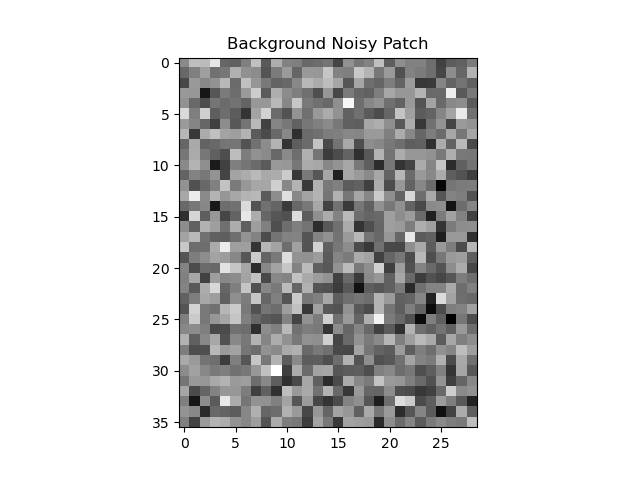

In [ ]:
yl, yh, xl, xh = select.bbox
noisy_background_patch = I[yl:yh+1, xl:xh+1]
plt.imshow(noisy_background_patch)
plt.title("Background Noisy Patch")
plt.show()

In [23]:
noisy_var = np.var(noisy_background_patch)
print(f"The variance of the background noise is {round(noisy_var, 4)}")

The variance of the background noise is 0.0102


In [24]:
def lee_filter(img, filter_size, noisy_var):
    mn = np.ones((filter_size, filter_size))/ (filter_size*filter_size)
    local_mean = signal.convolve(img, mn, mode='same')
    local_var = signal.convolve(img**2, mn, mode='same') - local_mean**2
    K = np.maximum((local_var - noisy_var) / local_var, 0)
    denoised_lee_image = K * img + (1 - K) * local_mean
    plt.imshow(denoised_lee_image)  
    plt.title(f"Denoised Image with Lee Filtering, Filter Size = {filter_size}, Noisy Variance = {round(noisy_var, 3)}")
    plt.show()
    print(f"The PSNR between the original and lee filtered restored image with Filter Size = {filter_size}, Noisy Variance = {round(noisy_var, 3)} is {round(PSNR(f, denoised_lee_image), 3)}")
    return denoised_lee_image

In [25]:
# copy code given in lab
mn = np.ones((5,5))/25
local_mean = signal.convolve(I, mn, mode='same')
local_var = signal.convolve(I**2, mn, mode='same') - local_mean**2
local_mean.shape, local_var.shape, I.shape

((256, 256), (256, 256), (256, 256))

In [26]:
local_var.min(), local_var.max()

(0.0004281430219145309, 0.1618278262206843)

In [27]:
K = (local_var - noisy_var) / (local_var)
K.shape, np.max(K), np.min(K)

((256, 256), 0.9371966330746501, -22.73817119200478)

In [28]:
# note: K cannot be < 0, cut if off
K = np.maximum(K, 0)
K.shape, np.max(K), np.min(K)

((256, 256), 0.9371966330746501, 0.0)

In [29]:
# plot the original and denoised image
denoised_lee_image = K * I + (1 - K) * local_mean
denoised_lee_image.min(), denoised_lee_image.max()

(0.010980392156862738, 0.9642352941176472)

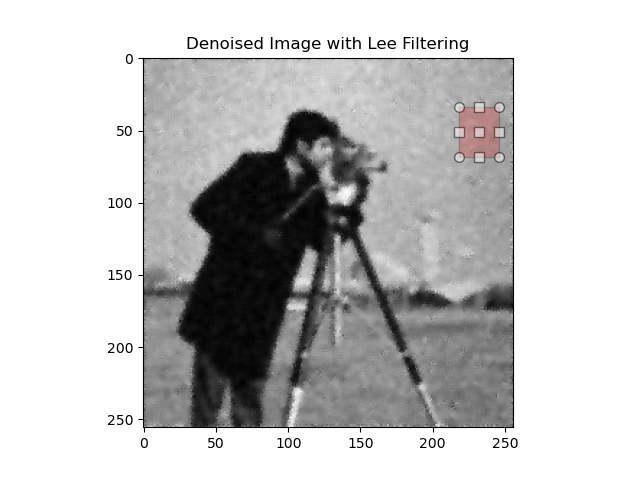

In [30]:
plt.imshow(denoised_lee_image)  
plt.title("Denoised Image with Lee Filtering")
plt.show()

In [31]:
print(f"The PSNR between the original and lee filtered restored image is {round(PSNR(f, denoised_lee_image), 2)}")

The PSNR between the original and lee filtered restored image is 22.16


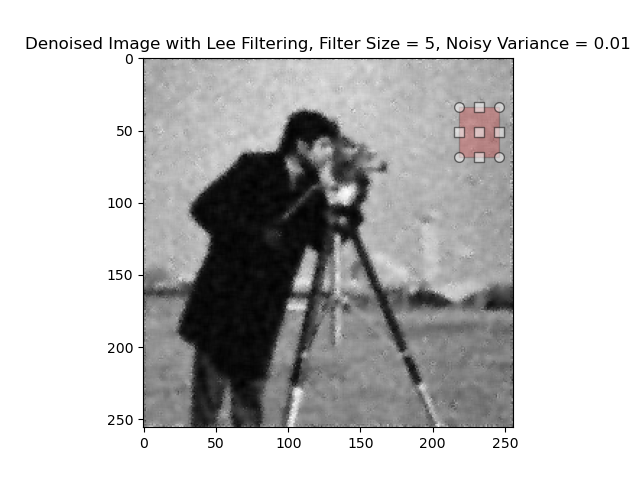

The PSNR between the original and lee filtered restored image with Filter Size = 5, Noisy Variance = 0.01 is 22.161


In [36]:
lee_filtered_img = lee_filter(I, 5, noisy_var)

In [33]:
def gaussian_filter(n_rows, n_cols, stdv):
    """
    Returns a 2d Gaussian image filter.
    """
    g_r = signal.windows.gaussian(n_rows, stdv)
    g_c = signal.windows.gaussian(n_cols, stdv)

    G = np.outer(g_r, g_c)

    return G/np.max(G)

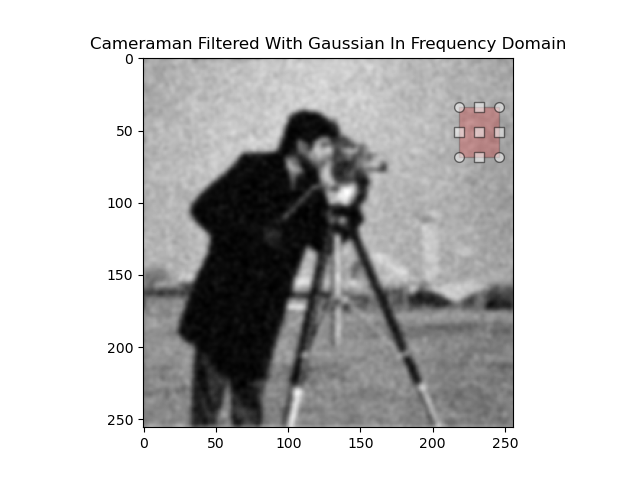

In [37]:
# q7: compare the result to a gaussian LPF with sigma = 30
degraded_cameraman_frequency = np.fft.fftshift(np.fft.fft2(I))
nrow, ncol = I.shape
gaussian = gaussian_filter(nrow, ncol, 30)
filtered_cameraman_freq = degraded_cameraman_frequency * gaussian

# Perform inverse Fourier transform to get the filtered image
filtered_cameraman_gaussian = np.abs(np.fft.ifft2(filtered_cameraman_freq))
plt.imshow(filtered_cameraman_gaussian)
plt.title("Cameraman Filtered With Gaussian In Frequency Domain")
plt.show()

In [35]:
print(f"The PSNR between the original and gaussian filtered (in frequency domain) image is {round(PSNR(f, filtered_cameraman_gaussian), 2)}")

The PSNR between the original and gaussian filtered (in frequency domain) image is 22.11


Q7 comment. We note that in terms of PSNR, the performance of the Gaussian low pass filter is close to that of the lee filter. However, from visual inspection we note some key differences. In areas of high detail, the lee filter visually performs better; the features of the cameraman and the camera are much more clean for the lee filter compared to the gaussian filter (which makes sense as the lee filter would calculate a high SNR in these regions and thus keep the details). The gaussian filter smooths the details in these regions. For areas of low detail, both filters perform similarly (as expected). There is a small discrepancy where the lee filter brings out some noisy in the low detail regions as a result of the statistics, however it is rarely happening.

In [38]:
print(f"The variance before was {round(noisy_var, 4)}")

The variance before was 0.0102


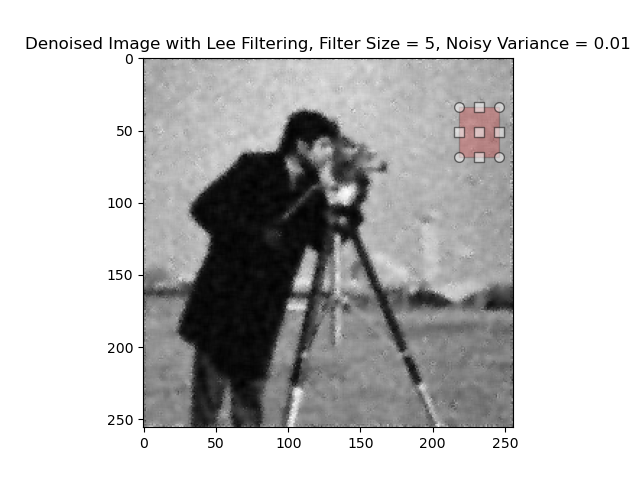

The PSNR between the original and lee filtered restored image with Filter Size = 5, Noisy Variance = 0.01 is 22.161


In [39]:
lee_filtered = lee_filter(I, 5, noisy_var)

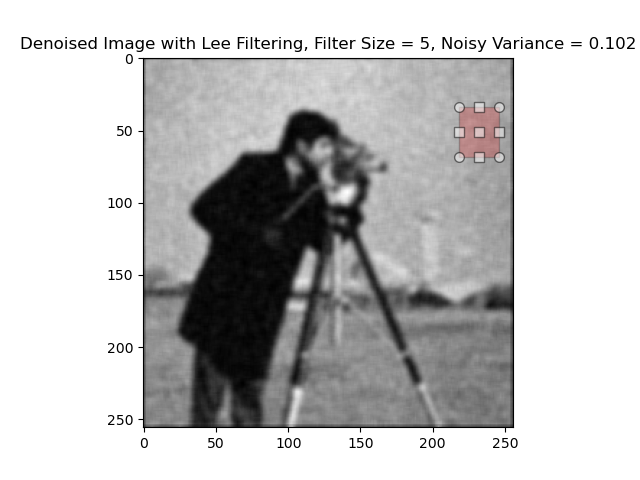

The PSNR between the original and lee filtered restored image with Filter Size = 5, Noisy Variance = 0.102 is 21.459


In [40]:
# q8 - change the variance both above and below what we computed from before and observe results
# note that the variance from before was about 0.01
lee_filtered_var_up = lee_filter(I, 5, noisy_var*10)

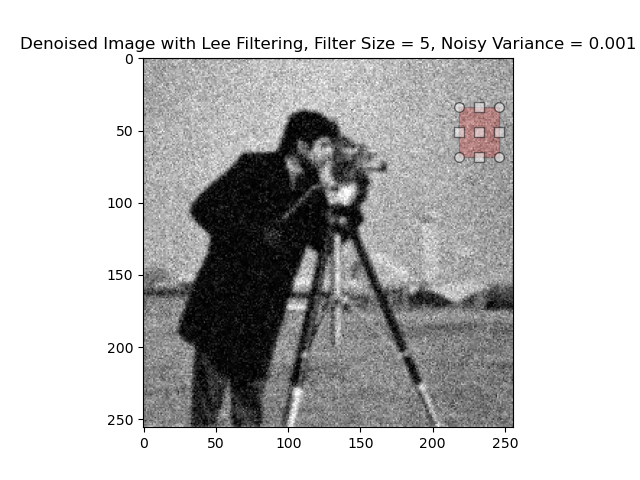

The PSNR between the original and lee filtered restored image with Filter Size = 5, Noisy Variance = 0.001 is 19.422


In [41]:
lee_filtered_var_down = lee_filter(I, 5, noisy_var/10)

Q8 comment. When we increase the noise variance by an order of magnitude more, we observe that the whole image gets blurred, similar to what we observe when applying a gaussian low pass filter. The reason for this is that we are increasing the threshold at which we expect noise. As a result, the SNR is generally lower, so the lee filter will tend to output the mean of the patch (because with low SNR, we think there is more noise so we must blur to compensate). We observe the converse when we decrease the noise variance by an order of magnitude. In this case, the low noise variance means that the SNR is generally high, meaning that we take the original pixels a lot of the time since we believe there to be lots of signal in the image (and thus the resultant image has a lot of noise). We can generalize the following:

1. If the noise variance is too high for the lee filter, then actual signal will get drowned out by the high noise in the statistic calculation in the image and it will be overblurred.
2. If the noise variance is too low for the lee filter, then noise will begin to appear as actual signal in the statistic calculation in the image and too much noise will appear in the resultant image.

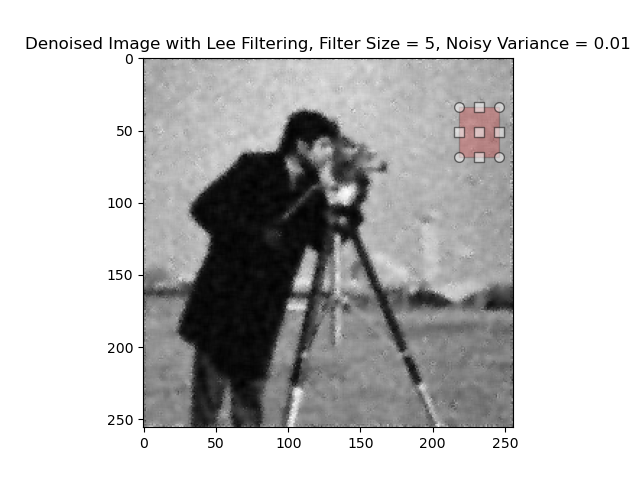

The PSNR between the original and lee filtered restored image with Filter Size = 5, Noisy Variance = 0.01 is 22.161


In [42]:
lee_filtered = lee_filter(I, 5, noisy_var)

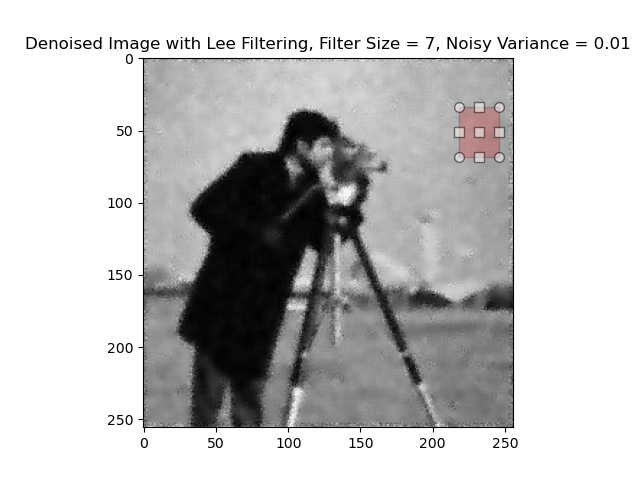

The PSNR between the original and lee filtered restored image with Filter Size = 7, Noisy Variance = 0.01 is 22.002


In [47]:
# Q9
lee_filtered_larger_window = lee_filter(I, 7, noisy_var)

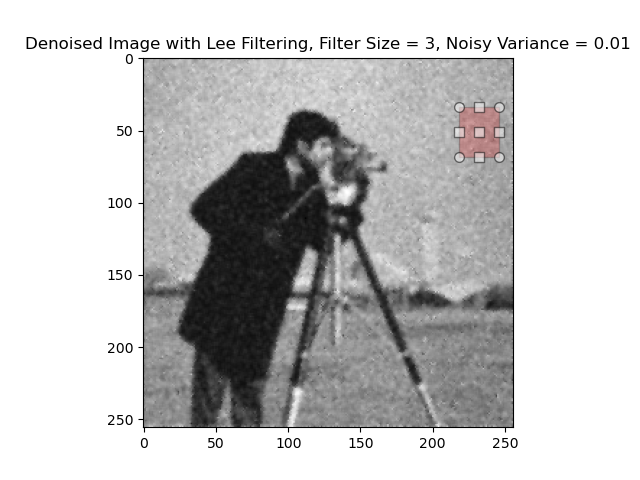

The PSNR between the original and lee filtered restored image with Filter Size = 3, Noisy Variance = 0.01 is 22.123


In [48]:
lee_filtered_smaller_window = lee_filter(I, 3, noisy_var)

Q9 comment. As we increase the window size (from 5x5 -> 7x7) we notice that the image looks slightly more crisp, but has extra artifacts appearing around the edges (ie. around the head, jacket, and camera). The reason for the more crisp looking image is that bigger filters have better statistic calculations, as we have more samples. However, the artifacts around the edges are a result of outliers appearing in some of the largers windows that cover mostly background but have some edges inside. The windows which include small parts of edges have outliers which will then skew the statistics and create slight artifacts around the edges. When we decrease the window size, we notice that the resultss get worse as the image looks more noisy. The reason for the noisy looking image are that the small windows have statistic calculations which are not good estimates (due to the low number of samples in each window) and as a result brings out the noise in image.